Confusion Matrix (True Labels vs. Cluster Labels):
[[473732 336693]
 [  2140   2999]]
Adjusted Rand Index: 0.0014454839686530768

Classification Report for KMeans Clustering:
              precision    recall  f1-score   support

 A2 (Injury)       1.00      0.58      0.74    810425
  A1 (Fatal)       0.01      0.58      0.02      5139

    accuracy                           0.58    815564
   macro avg       0.50      0.58      0.38    815564
weighted avg       0.99      0.58      0.73    815564



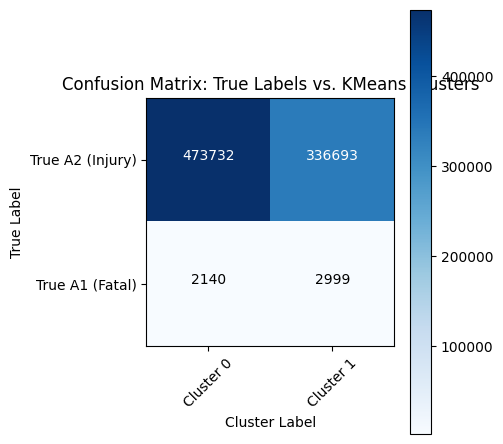

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) Load & Combine Data from years 108 to 112
# ------------------------------------------------
def load_year_data(year, file_type):
    # file_type: 'A1' or 'A2'
    path = f"dataset/{file_type}/{year}_{file_type}_cleaned.csv"
    df = pd.read_csv(path)
    # Assign label: 1 for A1 (fatal), 0 for A2 (injury)
    df["label"] = 1 if file_type == "A1" else 0
    return df

train_years = ["108", "109", "110", "111", "112"]
train_dfs_A1 = [load_year_data(year, "A1") for year in train_years]
train_dfs_A2 = [load_year_data(year, "A2") for year in train_years]

# Combine all training data (labels are kept only for evaluation)
df = pd.concat(train_dfs_A1 + train_dfs_A2, ignore_index=True)

# ------------------------------------------------
# 2) Preprocess Features
# ------------------------------------------------
# Define the feature columns (categorical values are already numeric)
categorical_cols = [
    "weather",
    "lighting",
    "road_condition",
    "traffic_signal",
    "vehicle_type",
    "gender",
    "protective_equipment"
]
numeric_cols = ["speed_limit", "age"]

# Remove rows with missing values
df.dropna(subset=categorical_cols + numeric_cols + ["label"], inplace=True)
df[categorical_cols] = df[categorical_cols].astype(int)

# Define feature matrix X and true labels y (for evaluation only)
X = df[categorical_cols + numeric_cols]
y_true = df["label"]

# ------------------------------------------------
# 3) Perform Unsupervised Learning (KMeans Clustering)
# ------------------------------------------------
# Set n_clusters=2 since we expect two groups (A1 vs. A2)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# ------------------------------------------------
# 4) Evaluate Clustering Performance
# ------------------------------------------------
# Compute a confusion matrix comparing true labels with cluster assignments.
# Note: Cluster labels (0, 1) are arbitrary.
cm = confusion_matrix(y_true, cluster_labels)
print("Confusion Matrix (True Labels vs. Cluster Labels):")
print(cm)

# Compute an Adjusted Rand Index as an unsupervised clustering metric
ari = adjusted_rand_score(y_true, cluster_labels)
print("Adjusted Rand Index:", ari)

# Since the cluster numbering is arbitrary, one approach to evaluate performance is
# to map the cluster labels to the true labels based on majority voting in the confusion matrix.
# Here we choose a mapping based on the counts.
mapping = {}
if cm[0, 0] + cm[1, 0] > cm[0, 1] + cm[1, 1]:
    mapping[0] = 0
    mapping[1] = 1
else:
    mapping[0] = 1
    mapping[1] = 0

pred_labels = np.array([mapping[label] for label in cluster_labels])
print("\nClassification Report for KMeans Clustering:")
print(classification_report(y_true, pred_labels, target_names=["A2 (Injury)", "A1 (Fatal)"]))

# ------------------------------------------------
# 5) Plot the Confusion Matrix for Clustering
# ------------------------------------------------
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix: True Labels vs. KMeans Clusters")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Cluster 0", "Cluster 1"], rotation=45)
plt.yticks(tick_marks, ["True A2 (Injury)", "True A1 (Fatal)"])

# Annotate cells with counts
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Cluster Label")
plt.tight_layout()
plt.show()
